# Convert Bounding Box to Masks 

The goal is to find the mask of an object using the bounding box coordinates. Then use the mask and image to create a COCO format JSON file. It is required to create a dataset for applying an instance segmentation algorithm.


To find the mask of an object inside an image, a state-of-an-art algorithm called Deep MAC will be used. Input to the [Deep MAC](https://arxiv.org/abs/2104.00613) algorithm will be the normalized bounding box coordinate and an image. Its output will be a mask. Deep MAC pre trained weights trained on a SpineNet backbone will be used to detect the masks. These weights are available in open source. Deep MAC inference script can be [found here](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/deepmac_colab.ipynb) as well but we modified it according to the our project's need. 


The output mask and its corresponding image will be then used to create a COCO format JSON annotation file using an open source library known as Imantics.

## Import libraries & clone the TF models directory

In [ ]:
# install additional libraries
!pip install tf-models-official
!pip3 install imantics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 4.6 MB 56.7 MB/s 
     |████████████████████████████████| 1.1 MB 41.8 MB/s 
     |████████████████████████████████| 238 kB 8.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 636 kB 69.9 MB/s 
     |████████████████████████████████| 352 kB 60.2 MB/s 
     |████████████████████████████████| 116 kB 46.9 MB/s 
     |████████████████████████████████| 1.3 MB 20.9 MB/s 
     |████████████████████████████████| 5.8 MB 42.9 MB/s 
     |████████████████████████████████| 438 kB 56.1 MB/s 
     |████████████████████████████████| 1.6 MB 6.0 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=9a

In [ ]:
%matplotlib inline

import logging
logging.disable(logging.WARNING)

from matplotlib import pyplot as plt
from matplotlib import patches
from PIL import Image
import numpy as np
import random
from skimage import color
from skimage.color import rgb_colors
from skimage import transform
from skimage import util
import tensorflow as tf
import warnings
from imantics import Mask, Category, Image as imantics_Image
import json
tf.compat.v1.enable_eager_execution()


COLORS = ([rgb_colors.cyan, rgb_colors.orange, rgb_colors.pink,
           rgb_colors.purple, rgb_colors.limegreen , rgb_colors.crimson] + 
          [(color) for (name, color) in color.color_dict.items()])

## Visualization functions

In [ ]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                     image_width, resize_method='bilinear'):
  """Transforms the box masks back to full image masks.

  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.

  Args:
    box_masks: A tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.
    resize_method: The resize method, either 'bilinear' or 'nearest'. Note that
      'bilinear' is only respected if box_masks is a float.

  Returns:
    A tensor of size [num_masks, image_height, image_width] with the same dtype
    as `box_masks`.
  """
  resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""

    num_boxes = tf.shape(box_masks)[0]
    box_masks_expanded = tf.expand_dims(box_masks, axis=3)

    resized_crops = tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reframe_image_corners_relative_to_boxes(boxes),
        box_indices=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        method=resize_method,
        extrapolation_value=0)
    return tf.cast(resized_crops, box_masks.dtype)

  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
  return tf.squeeze(image_masks, axis=3)

def reframe_image_corners_relative_to_boxes(boxes):
  """Reframe the image corners ([0, 0, 1, 1]) to be relative to boxes.

  The local coordinate frame of each box is assumed to be relative to
  its own for corners.

  Args:
    boxes: A float tensor of [num_boxes, 4] of (ymin, xmin, ymax, xmax)
      coordinates in relative coordinate space of each bounding box.

  Returns:
    reframed_boxes: Reframes boxes with same shape as input.
  """
  ymin, xmin, ymax, xmax = (boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3])

  height = tf.maximum(ymax - ymin, 1e-4)
  width = tf.maximum(xmax - xmin, 1e-4)

  ymin_out = (0 - ymin) / height
  xmin_out = (0 - xmin) / width
  ymax_out = (1 - ymin) / height
  xmax_out = (1 - xmin) / width
  return tf.stack([ymin_out, xmin_out, ymax_out, xmax_out], axis=1)


## Utility functions

In [ ]:
def read_image(path):
  """Read an image and optionally resize it for better plotting."""
  with tf.io.gfile.GFile(path, 'rb') as f:
    img = Image.open(f)
    return np.array(img, dtype=np.uint8)

def resize_for_display(image, max_height=600):
  height, width, _ = image.shape
  width = int(width * max_height / height)
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    return util.img_as_ubyte(transform.resize(image, (height, width)))


def get_mask_prediction_function(model):
  """Get single image mask preidction function using a model."""

  detection_fn = model.signatures['serving_default']


  @tf.function
  def predict_masks(image, boxes):
    height, width, _ = image.shape.as_list()
    batch = image[tf.newaxis]
    boxes = boxes[tf.newaxis]
    detections = detection_fn(images=batch, boxes=boxes)
    masks = detections['detection_masks']
    return reframe_box_masks_to_image_masks(masks[0], boxes[0],
                                                height, width)
    
  return predict_masks


def display(im):
  plt.figure(figsize=(16, 12))
  plt.imshow(im)
  plt.show()

def plot_image_annotations(image, boxes, masks=None, darken_image=0.7):
  fig, ax = plt.subplots(figsize=(16, 12))
  ax.set_axis_on()
  image = (image * darken_image).astype(np.uint8)
  ax.imshow(image)

  height, width, _ = image.shape

  num_colors = len(COLORS)
  color_index = 0
  boxes = boxes[:20]
  
  masks_list = masks if masks is not None else [None] * len(boxes)
  for box, mask in zip(boxes, masks_list):
    ymin, xmin, ymax, xmax = box
    ymin *= height
    ymax *= height
    xmin *= width
    xmax *= width

    color = COLORS[color_index]
    color = np.array(color)
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2.5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    if masks is not None:
      mask = (mask > 0.5).astype(np.float32)
      color_image = np.ones_like(image) * color[np.newaxis, np.newaxis, :]
      color_and_mask = np.concatenate(
          [color_image, mask[:, :, np.newaxis]], axis=2)

      ax.imshow(color_and_mask, alpha=0.5)

    color_index = (color_index + 1) % num_colors

  return ax

## Import pre-trained Deep MAC weights

In [ ]:
!wget https://storage.googleapis.com/tf_model_garden/vision/deepmac_maskrcnn/deepmarc_spinenet.zip
!unzip deepmarc_spinenet.zip

--2022-08-11 23:49:21--  https://storage.googleapis.com/tf_model_garden/vision/deepmac_maskrcnn/deepmarc_spinenet.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314902579 (300M) [application/zip]
Saving to: ‘deepmarc_spinenet.zip’

deepmarc_spinenet.z 100%[===================>] 300.31M   142MB/s    in 2.1s    

2022-08-11 23:49:24 (142 MB/s) - ‘deepmarc_spinenet.zip’ saved [314902579/314902579]

Archive:  deepmarc_spinenet.zip
   creating: deepmarc_spinenet/
   creating: deepmarc_spinenet/variables/
  inflating: deepmarc_spinenet/variables/variables.data-00000-of-00001  
  inflating: deepmarc_spinenet/variables/variables.index  
   creating: deepmarc_spinenet/assets/
  inflating: deepmarc_spinenet/saved_model.pb  


## Load the model

In [ ]:
MODEL = '/content/deepmarc_spinenet/'
model = tf.saved_model.load(MODEL)
prediction_function = get_mask_prediction_function(model)

## MUST CHANGE - Modify the path of an image according to your convenience

In [ ]:
# import an image
!curl -O https://raw.githubusercontent.com/tensorflow/models/master/official/projects/waste_identification_ml/pre_processing/config/sample_images/image_3.jpg 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1235k  100 1235k    0     0  3687k      0 --:--:-- --:--:-- --:--:-- 3676k


In [ ]:
# path to an image
IMAGE_PATH = 'image_3.jpg' #@param {type:"string"}

# list of bounding box coordinates in the ymin, xmin, ymax, xmax format
BB_CORD = [175.0, 815.06625, 948.0, 1630.125] #@param {type:"raw"}

In [ ]:
# get height and width of an image
im = read_image(IMAGE_PATH)
height, width, _ = im.shape
print(height, width)

# convert bounding box coordinates to normalized coordinates
YMIN, XMIN, YMAX, XMAX = BB_CORD[0], BB_CORD[1], BB_CORD[2], BB_CORD[3]
YMIN_NOR, XMIN_NOR, YMAX_NOR, XMAX_NOR = YMIN/height, XMIN/width, YMAX/height, XMAX/width
print(YMIN_NOR, XMIN_NOR, YMAX_NOR, XMAX_NOR)

# reshape the coordinates
boxes = np.array([YMIN_NOR, XMIN_NOR, YMAX_NOR, XMAX_NOR]).reshape(1,4)
boxes

2048 2592
0.08544921875 0.3144545717592592 0.462890625 0.62890625


array([[0.08544922, 0.31445457, 0.46289062, 0.62890625]])

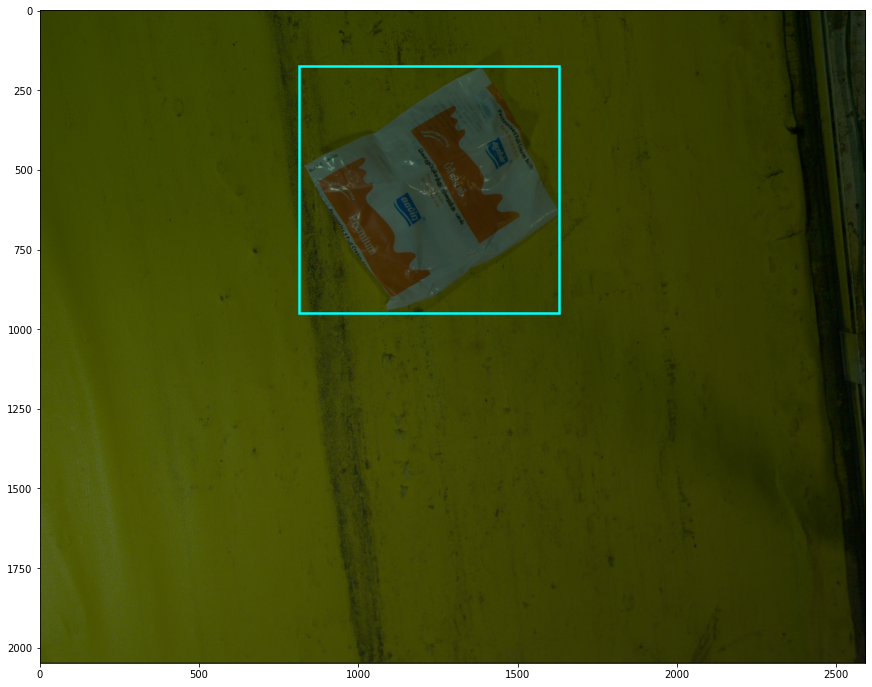

In [ ]:
%matplotlib inline
# display bounding box over an image
plot_image_annotations(im, boxes)

## Doing the inference and showing the results

In [ ]:
masks = prediction_function(tf.convert_to_tensor(im),
                            tf.convert_to_tensor(boxes, dtype=tf.float32))

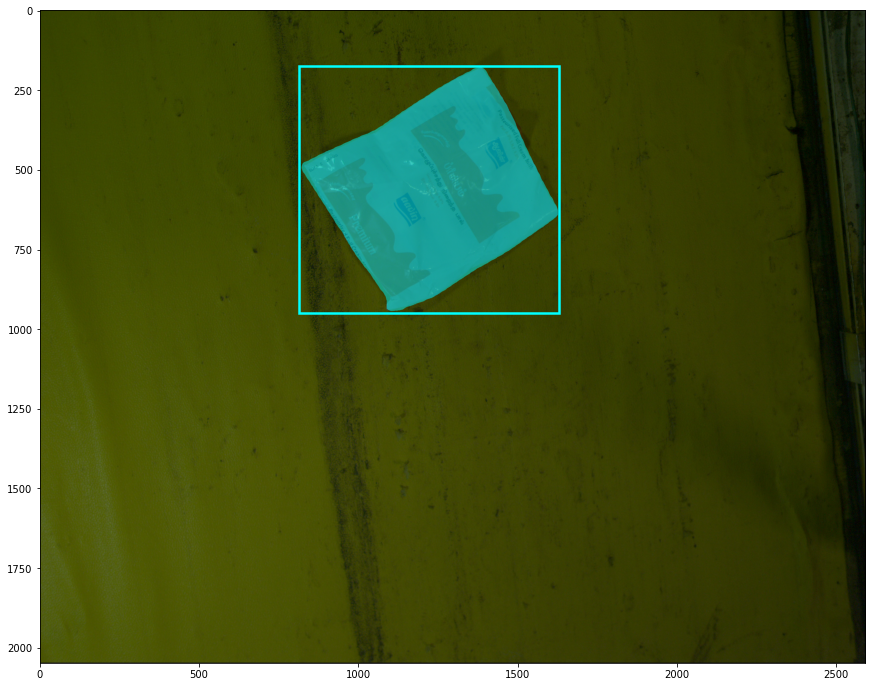

In [ ]:
plot_image_annotations(im, boxes, masks.numpy())
plt.show()

## Get the mask

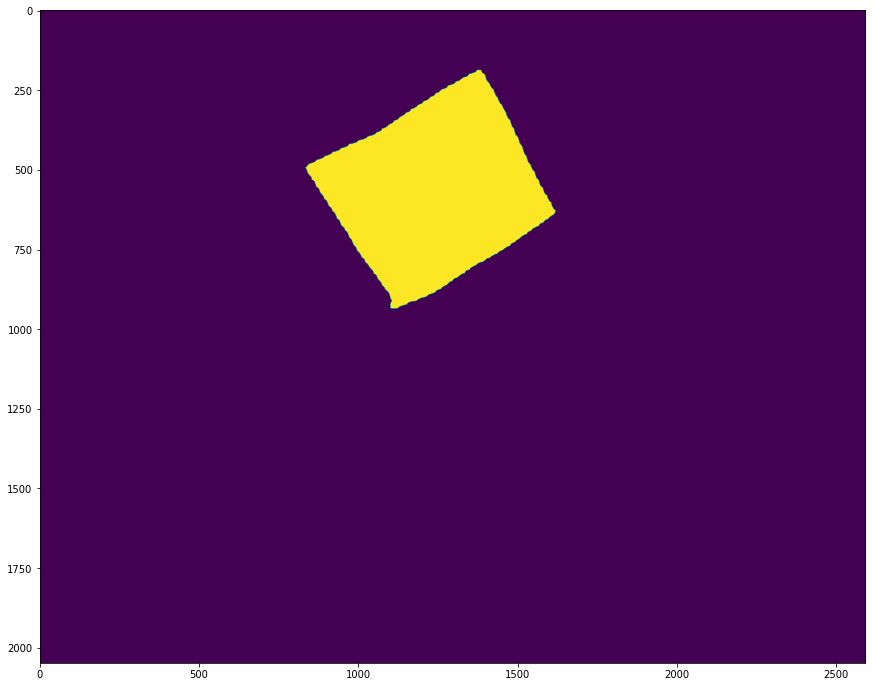

In [ ]:
mask = masks[0].numpy().reshape(im.shape[0], im.shape[1])
mask = np.where(mask > 0.90, 1, 0)
mask = np.array(mask, dtype=np.uint8)
display(mask)

# Convert Mask & Image to COCO JSON



In [ ]:
# use of imantics library

# give the path of an image
image = imantics_Image.from_path(IMAGE_PATH)

# array of the mask
mask = Mask(mask)

# define the category of an object
image.add(mask, category=Category("Category Name"))  

# create a dict of coco
coco_json = image.export(style='coco')
coco_json.keys()

# write coco_json dict to coco.json
open('coco.json', "w").write(json.dumps(coco_json, indent=4))

64187

In [ ]:
# display the categories
coco_json['categories']

[{'color': '#1fab35',
  'id': 1,
  'metadata': {},
  'name': 'Category Name',
  'supercategory': None}]

In [ ]:
# display image information
coco_json['images']

[{'coco_url': None,
  'date_captured': None,
  'fickr_url': None,
  'file_name': 'image_3.jpg',
  'height': 2048,
  'id': 0,
  'license': None,
  'metadata': {},
  'path': 'image_3.jpg',
  'width': 2592}]

In [ ]:
# display bounding box
coco_json['annotations'][0]['bbox']

(833, 188, 784, 747)